In [1]:
# CRAG introduces corrective mechanism that assess and refine the quality of retrieved documents.

import os
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser

from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import List, TypedDict
from langchain_core.documents import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from pprint import pprint
from langchain_core.runnables.graph import CurveStyle, NodeStyles, MermaidDrawMethod
from IPython.display import display, HTML, Image

from dotenv import load_dotenv

load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
print(f"OpenAI API key loaded: {openai_key is not None}")

OpenAI API key loaded: True


In [11]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

print("Starting document loading...")
# load and split documents
docs = [WebBaseLoader(url).load() for url in urls]
print(f"Loaded {len(docs)} documents from URLs.")
docs_list = [item for sublist in docs for item in sublist]
print(f"Flattened to {len(docs_list)} document items.")
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)
print(f"Split into {len(doc_splits)} document chunks.")

Starting document loading...
Loaded 3 documents from URLs.
Flattened to 3 document items.
Split into 187 document chunks.


In [14]:
print("Creating vectorstore...")
# add to vectorstore
persist_dir = "./chroma_db"
vectorstore = Chroma.from_documents(
    doc_splits,
    collection_name="crag-chroma",
    embedding=OpenAIEmbeddings(model="text-embedding-3-small", api_key=openai_key),
    persist_directory=persist_dir,
)
print("Vectorstore created.")

retriever = vectorstore.as_retriever()
print("Retriever created.")

Creating vectorstore...
Vectorstore created.
Retriever created.


In [28]:
# step 2: define graders and relevance model
class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

retrieval_prompt = ChatPromptTemplate.from_template("""You are a grader assessing if a document is relevant to a user's question.
                                                    Document: {document}
                                                    Question: {question}
                                                    Is the document relevant? Answer 'yes' or 'no' """)

retrieval_grader = retrieval_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(GradeDocuments)


In [17]:
# step 3: query re-writer
class ImproveQuestion(BaseModel):
    improved_question: str = Field(description="Formulate an improved question")

re_write_prompt = ChatPromptTemplate.from_template("Here is the initial question: \n\n {question} \n Formulate an improved question.")
query_rewriter = re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(ImproveQuestion)

# Define prompt template
prompt = ChatPromptTemplate.from_template("""
Use the following context to answer the question:
Question: {question}
Context: {context}
Answer:
""")


rag_chain = prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()

In [19]:
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]

# step 4: define workflow nodes

def retrieve(state):
    print("[Node] Starting retrieve...")
    question = state["question"]
    print(f"Retrieving documents for question: {question}")
    documents = retriever.invoke(question)
    print(f"Retrieved {len(documents)} documents.")
    return {"documents": documents, "question": question}

def grade_documents(state):
    print("[Node] Starting grade_documents...")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search_needed = "No"
    print(f"Grading {len(documents)} documents for relevance...")

    for i, doc in enumerate(documents):
        print(f"Grading document {i+1}/{len(documents)}...")
        grade = retrieval_grader.invoke({"question": question, "document": doc.page_content}).binary_score
        print(f"Grade result: {grade}")
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT--")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search_needed = "Yes"
            print(f"Web search needed: {web_search_needed}")
            return {"documents": filtered_docs, "question":question, "web_search": web_search_needed}
    
    print(f"Filtered to {len(filtered_docs)} relevant documents.")
    return {"documents": filtered_docs, "question": question, "web_search": web_search_needed}

In [23]:
def transform_query(state):
    print("[Node] Starting transform_query...")
    question = state["question"]
    print(f"Original question: {question}")
    rewritten_question = query_rewriter.invoke({"question": question})
    print(f"Rewritten question: {rewritten_question.improved_question}")
    return {"question": rewritten_question.improved_question, "documents":state["documents"]}

def web_search(state):
    print("[Node] Starting web_search...")
    """
    Web search based on the re-phrased question.
    
    Args:
        state(dict): The current graph state
        
    Returns:
        state(dict): Updates documents key with append web results
    """
    print("---WEBSEARCH---")

    question = state["question"]
    documents = state["documents"]
    pprint(question+"\n")

    print("Invoking Tavily search...")
    # perform web search using TavilySearchResults and extract only the 'content' field for Document
    search_results = TavilySearchResults(k=3).invoke({"query": question})
    print(f"Tavily search returned {len(search_results)} results.")

    # process results to create Document objects only with page_content
    web_documents = [
        Document(page_content=result["content"]) for result in search_results if "content" in result
    ]
    print(f"Created {len(web_documents)} web documents.")

    # append web search results to the existing documents
    documents.extend(web_documents)
    print(f"Total documents now: {len(documents)}")
    return {"documents": documents, "question": question}

def generate(state):
    print("[Node] Starting generate...")
    print(f"Generating answer for question: {state['question']}")
    generation = rag_chain.invoke({"context": state["documents"], "question": state["question"]})
    print("Generation completed.")
    return {"generation": generation}

In [24]:
# step 5: Define decision-making logic
def decide_to_generate(state):
    print("[Node] Starting decide_to_generate...")
    """
    Determines whether to generate an answer or re-generate a question
    
    Args:
        state(dict): The current graph state
        
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    print(f"Web search flag: {web_search}")
    if web_search == "Yes":
        # all documents have been filtered check_relevance, we will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION TRANSFORM QUERY---")
        return "transform_query"
    else:
        print("---DECISION: GENERATE ANSWER---")
        return "generate"

In [25]:
# step 6: Build the workflow
print("Building workflow...")
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)
workflow.add_node("generate", generate)

# Add edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query", "generate": "generate"})
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

print("Compiling workflow...")
app = workflow.compile()
print("Workflow compiled successfully.")

Building workflow...
Compiling workflow...
Workflow compiled successfully.


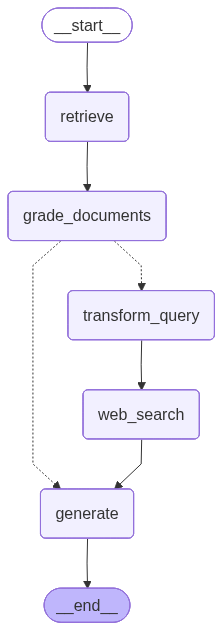

In [26]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

In [29]:
inputs = {"question": "Explain how the different types of memory work?"}

print("Starting workflow execution...")
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        # print the full state of each node
        pprint(value, indent=2, width=80, depth=None)
        print("\n---\n")
print("Workflow execution completed.")

Starting workflow execution...
[Node] Starting retrieve...
Retrieving documents for question: Explain how the different types of memory work?
Retrieved 4 documents.
Node 'retrieve':
{ 'documents': [ Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistak

C:\Users\re_zi\AppData\Local\Temp\ipykernel_171980\2044079010.py:28: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_results = TavilySearchResults(k=3).invoke({"query": question})


Tavily search returned 5 results.
Created 5 web documents.
Total documents now: 8
Node 'web_search':
{ 'documents': [ Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resul